<a href="https://colab.research.google.com/github/DeepeshAgarawal/portfolio-utils/blob/main/NAV_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authorizing Gdrive to access sheets

In [20]:
!pip install pandas-datareader
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
from datetime import date
from datetime import timedelta
import numpy as np 
gc = gspread.authorize(GoogleCredentials.get_application_default())

## Reading the tradebook provided by your broker

Reading a Google Sheet which contains all the buy/sell trasactions in your demat account (aka tradebook).

<p>Format of the tradebook:</p>

>Header|Description
>---|---
>Trade Date|Date of transaction
>Symbol|Symbol of the security traded as mentioned in Yahoo Finance
>Trade Type| buy or sell
>Qty|Quantity traded
>Price|Trade price

<p>Example entry:</p>

>Trade Date|Symbol|Trade Type|Qty|Price
>---|---|---|---|---
>2019-04-11|ASIANPAINT.NS|buy|5|1421


In [32]:
## Enter the URL of the Google Sheet
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1UMcytgb5_kkpnnnhf8RVbSzanispp-x44hiJTR94cGc/edit?usp=sharing')
sheet = wb.worksheet('Sheet1')
data_df = sheet.get_all_values()
df = pd.DataFrame(data_df)
df.columns = df.iloc[0]
df = df.iloc[1:]
df.head()
df['Trade Date'] = pd.to_datetime(df['Trade Date'])
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')
print(df.head())
start_date = df['Trade Date'].iloc[0]
symbols = df['Symbol'].unique() 

0 Trade Date         Symbol Trade Type  Qty    Price
1 2019-04-11  ASIANPAINT.NS        buy    5  1421.00
2 2019-04-11        RCOM.NS        buy  500     2.80
3 2019-06-07        RCOM.NS       sell    1     1.85
4 2019-07-31  ASIANPAINT.NS       sell    1  1510.00
5 2019-07-31  ASIANPAINT.NS       sell    2  1515.00


## Getting Data for the symbols present in the tradebook from Yahoo Finance.

In [22]:
#print(symbols)
panel_data = {}
for symbol in symbols:
  panel_data[symbol] = data.DataReader(symbol, 'yahoo', start_date, date.today() )['Close']
#print(panel_data)

## Getting Benchmark data

In [23]:
def normalize(arr):
  norm_arr=[]
  for k in arr:
    norm_arr.append(k*100/arr[0])
  return norm_arr

## Yahoo doesnt return historical closing prices of mid/small cap indices hence not using it for now, can replace it with other API calls
nifty = data.DataReader('^NSEI', 'yahoo', start_date, date.today())['Close']
#nifty_midcap150 = data.DataReader('BSEMID', 'quandl', start_date, date.today(), access_key="PfFeXvkrQaYu1dYs6Mdx")['Close']
nifty_midcap150 = data.DataReader('NIFTYMIDCAP150.NS', 'yahoo', start_date, date.today())['Close']
nifty_smallcap250 = data.DataReader('NIFTYSMLCAP250.NS', 'yahoo', start_date, date.today())['Close']

nifty_arr             =np.array(normalize(nifty))
nifty_midcap150_arr   =np.array(normalize(nifty_midcap150))
nifty_smallcap250_arr =np.array(normalize(nifty_smallcap250))

## Function to return trades upto a certain date

In [24]:
def get_holdings(holdings_date):
  return df[df['Trade Date']<=holdings_date]

## Function to factor in stock splits

If on the day of trasaction the 'Price' entry is > 2 times the closing price of that day it is considered as a stock split.

In [25]:

for index, row in df.iterrows():
    #to account for stock splits
    split = 1
    if (float(row['Price'])/float(panel_data[row['Symbol']][row['Trade Date']])) > 2:
      print("Found Split")
      print("Before split \n", df.loc[index])
      split = round(float(row['Price'])/float(panel_data[row['Symbol']][row['Trade Date']]))
      df.loc[index,('Qty')] = float(row['Qty'])*split
      df.loc[index,('Price')] = float(row['Price'])/split      
      print("\nAfter split \n", df.loc[index])


## Calculates the NAV, AUM and number of outstanding units of our mutual fund 

In [26]:
aum = 0
nav = 100
units = 0
ctr=0
cash=0
nav_arr = []
start_date = df['Trade Date'].iloc[0]

for i in nifty.keys():
  aum=0
  holding_current_df = get_holdings(i)   
  #print(holding_current_df)
  for index, row in holding_current_df.iterrows():
    if row['Trade Type'] == 'buy':
      if index > ctr:
        buy_val = float(row['Price'])*float(row['Qty'])*float(1.0)
        if buy_val >= cash:         
          units += (buy_val-cash)/nav        
          cash = 0              
        else:
          cash = cash - buy_val
      aum += float(panel_data[row['Symbol']][i])*float(row['Qty'])*float(1.0)
    else:
      if index > ctr:
        cash += float(row['Price'])*float(row['Qty']) # A sell order doesnt reduce the number of units however this cash is utilized in the next buy order to balance out the number of outstanding units
      aum += float(panel_data[row['Symbol']][i])*float(row['Qty'])*float(-1.0) 
  aum += cash
  ctr=holding_current_df.shape[0]
  nav = aum/units
  #units -= cash/nav
  #cash=0
  nav_arr.append(nav)
  #print(i)
  #print(cash,nav,units,aum)
  #print(holding_current_df)

## Plotting the relative return graphs for the past X days 

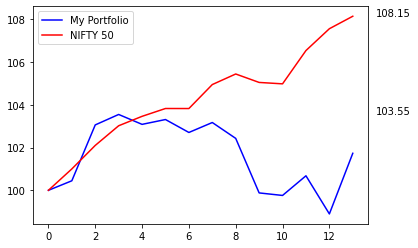

In [27]:
import matplotlib.pyplot as plt
def get_past_x_days_normalized_data(arr, days):
  temp = [arr[j] for j in range(len(arr)-days,len(arr))]
  temp_arr = np.array(normalize(temp))
  return temp_arr

def plot_past_x_days(past_days=365):
  temp_nav_arr = get_past_x_days_normalized_data(nav_arr,past_days)
  temp_nifty_arr = get_past_x_days_normalized_data(nifty_arr,past_days)
  #temp_nifty_midcap150_arr = get_past_x_days_normalized_data(nifty_midcap150_arr,past_days)
  #temp_nifty_smallcap250_arr = get_past_x_days_normalized_data(nifty_smallcap250_arr,past_days)
  plt.plot(temp_nav_arr,'b',label='My Portfolio')
  plt.plot(temp_nifty_arr,'r',label='NIFTY 50')
  #plt.plot(temp_nifty_midcap150_arr,'g',label='NIFTY Midcap 150')
  #plt.plot(temp_nifty_smallcap250_arr,'y',label='NIFTY Smallcap 250')
  plt.legend()
  for var in (temp_nav_arr, temp_nifty_arr):
      plt.annotate('%0.2f' % var.max(), xy=(1, var.max()), xytext=(8, 0), 
                  xycoords=('axes fraction', 'data'), textcoords='offset points')
  plt.show()


plot_past_x_days(14)